In [54]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as py
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.models import Model
from keras import backend as K

# Training a Lightweight Model to create super resolution satellite Images

1. Because of computational limits, a relatively lightweight solution is implemented
2. The Model uses 1 km MODIS Images, and creates a 250 meter visual product. 
3. The model is an autoencoder, which first encodes /upscales the 1 km images to a 4 km product, it then learns spatial features from the 4 km resolution image and tries to return it to the original 1km resolution
4. Further updates of this document will include implementation of custom loss functions to get sharper images.

## Loading the Satellite Imagery from the Repository
1. Unzip the files to load them into memory (too large for a github repository).

In [2]:
f = Dataset(r"C:\Users\rampaln\Downloads\Training_Dataset_Final.nc")
training_data = f['Reflectance'][:].data
X_train = training_data[0:1000]
X_test = training_data[1000:]

# Dataset
1. Consists of Cellular Clouds with Open-celled domains, closed-celled domains, disorganised cellular domains, and "stratus like clouds"
2. These are labelled in the Dataset (see dataset attributes).

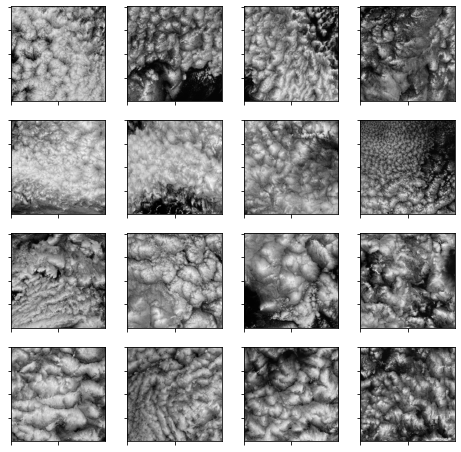

In [3]:
fig, ax = py.subplots(4,4, figsize = (8,8))
ax = ax.ravel()
for i, axes in enumerate(ax):
    axes.imshow(X_train[i], cmap ='gray')
    axes.set_yticklabels([])
    axes.set_xticklabels([])

## Creating a Model
1. Input shape is one-eighth of the original data

In [8]:
input_img = Input(shape=(100, 100, 1))  # adapt this if using `channels_first` image data format
x = Conv2D(16, (9, 9), activation='relu', padding='same')(input_img)
x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
encoded = Conv2D(1, (2, 2), activation='relu', padding='same')(x)
#x = Conv2D(512, (7, 7), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(encoded)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (2, 2), activation='relu', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')


In [5]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 16)      1312      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 16)      6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 16)        6416      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 16)        6416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 16)        0   

## Training the model (only training it on half the image domain)

In [9]:
#superresolution = Model(encoded, decoded)
sub_sample_train = X_train[:,:100,:100,np.newaxis]
sub_sample_test = X_test[:,:100,:100,np.newaxis]
autoencoder.fit(sub_sample_train,sub_sample_train,
                epochs=30,
                batch_size=40,
                shuffle=True,
                validation_data=(sub_sample_test,sub_sample_test))#,

Train on 1000 samples, validate on 421 samples
Epoch 1/30
1000/1000 [==============================] - 66s 66ms/step - loss: 0.0463 - val_loss: 0.0121
Epoch 2/30
1000/1000 [==============================] - 66s 66ms/step - loss: 0.0101 - val_loss: 0.0065
Epoch 3/30
1000/1000 [==============================] - 64s 64ms/step - loss: 0.0057 - val_loss: 0.0041
Epoch 4/30
1000/1000 [==============================] - 63s 63ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 5/30
1000/1000 [==============================] - 62s 62ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 6/30
1000/1000 [==============================] - 64s 64ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 7/30
1000/1000 [==============================] - 65s 65ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 8/30
1000/1000 [==============================] - 65s 65ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 9/30
1000/1000 [==============================] - 61s 61ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 10/30
1000/

In [113]:
autoencoder.save('model.h5')

In [96]:
encoding_dim = (200,200,1)
encoded_input = Input(shape=encoding_dim)
x = encoded_input
for layer in autoencoder.layers[-7:]:
    x = layer(x)
Models = Model(encoded_input, x)

In [97]:
data = Models.predict(X_test[:50,:,:,np.newaxis])

## Full Size Comparison of Super resolution vs Original Images
1. Full size examples are hard to compare, but images are slightly sharper
2. Sharpness of images will be improved in further updates
3. Original 1 km Image is on the left

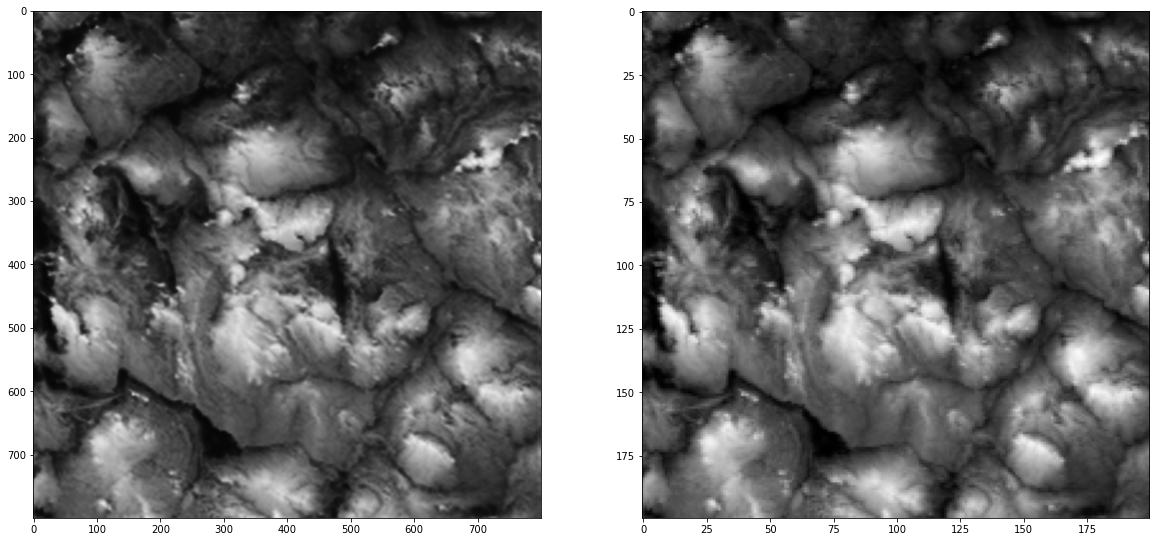

In [138]:
idx_of_interest = 10
fig, ax = py.subplots(1,2, figsize = (20,20))
ax[0].imshow(data[idx_of_interest,:,:,0], cmap ='gray')
ax[1].imshow(X_test[idx_of_interest,:,:], cmap='gray')

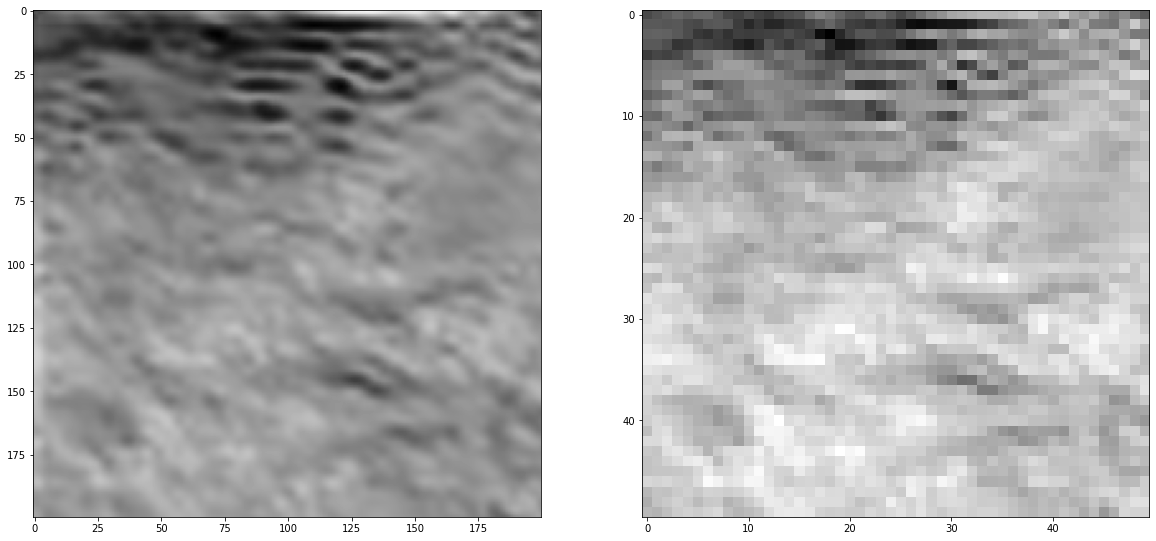

In [141]:
idx_of_interest = 46
fig, ax = py.subplots(1,2, figsize = (20,20))
cs = ax[0].imshow(data[idx_of_interest,:,:,0][:50*4,:50*4], cmap ='gray')#,vmin =0, vmax =0.8)
cs2 = ax[1].imshow(X_test[idx_of_interest,:,:][:50,:50], cmap='gray')#,vmin =0, vmax =0.8)
#ax4 = fig.add_axes([0.95,0.25,0.01,0.5])

# Examples of Images

1. Note the Images below are small segmentations of the original domains

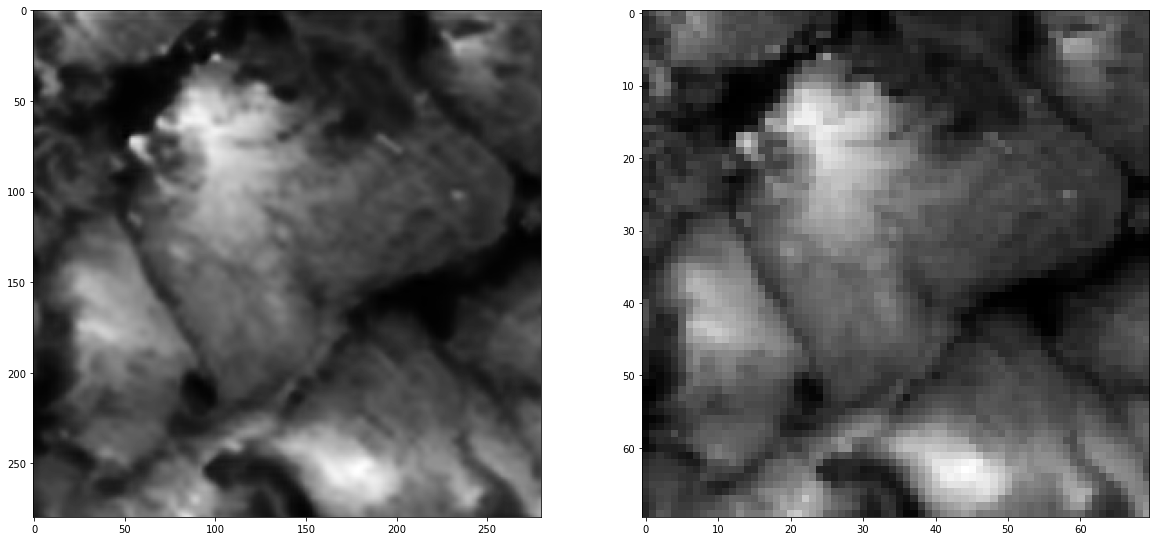

In [112]:
idx_of_interest = 10
fig, ax = py.subplots(1,2, figsize = (20,20))
ax[0].imshow(data[idx_of_interest,:,:,0][:70*4,:70*4], cmap ='gray')
ax[1].imshow(X_test[idx_of_interest,:,:][:70,:70], cmap='gray')
#ax[2].imshow(X_test[:,:100,:100,np.newaxis][idx_of_interest,::4,::4,0],cmap='gray')
#ax[2].imshow(X_test[idx_of_interest],cmap='gray')

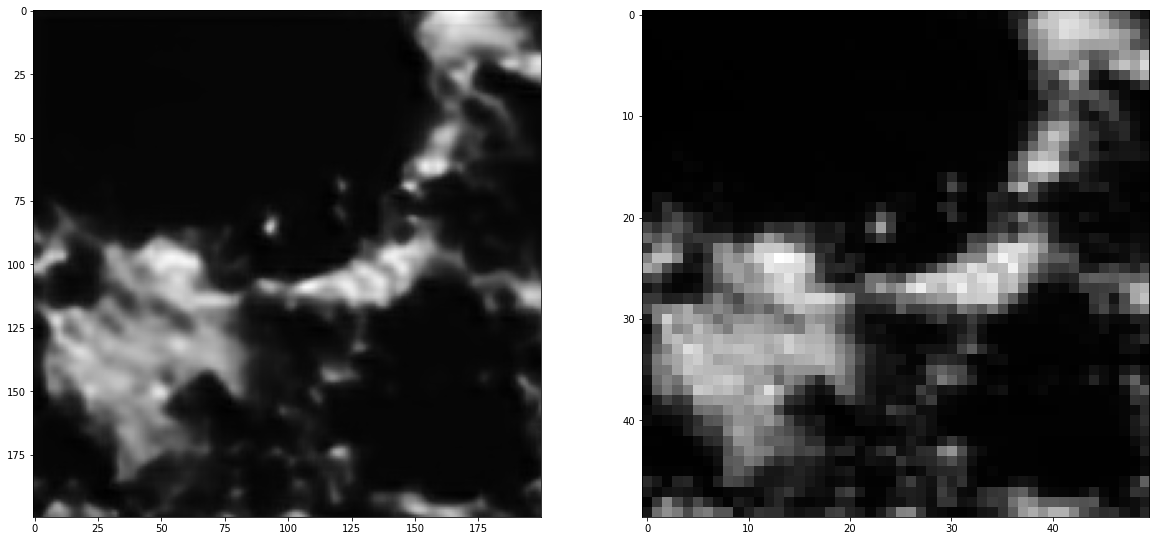

In [119]:
idx_of_interest = 19
fig, ax = py.subplots(1,2, figsize = (20,20))
ax[0].imshow(data[idx_of_interest,:,:,0][:50*4,:50*4], cmap ='gray')
ax[1].imshow(X_test[idx_of_interest,:,:][:50,:50], cmap='gray')

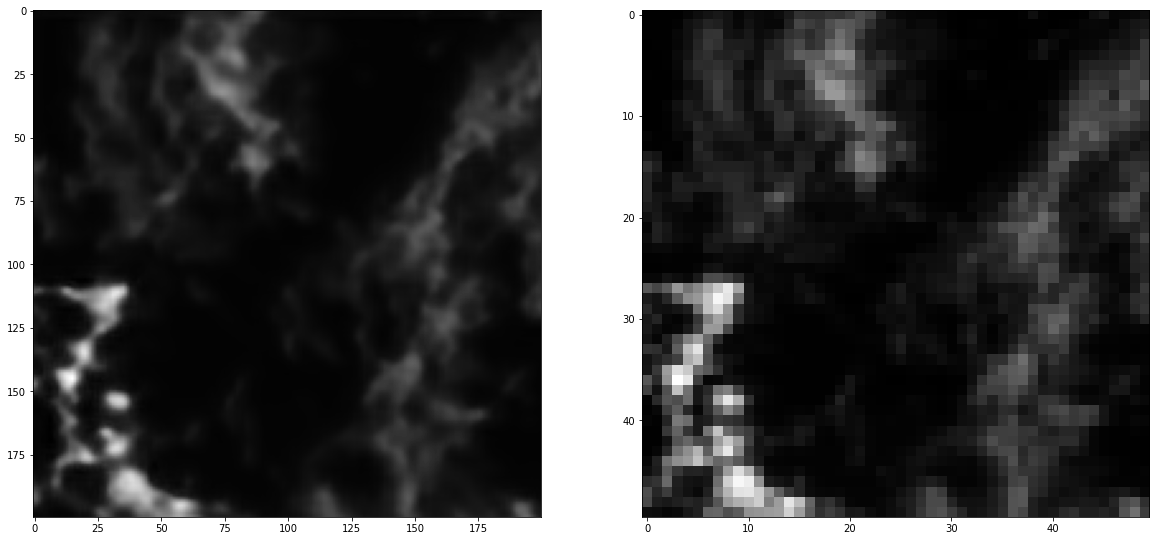

In [132]:
idx_of_interest = 25
fig, ax = py.subplots(1,2, figsize = (20,20))
cs = ax[0].imshow(data[idx_of_interest,:,:,0][:50*4,:50*4], cmap ='gray')#,vmin =0, vmax =0.8)
cs2 = ax[1].imshow(X_test[idx_of_interest,:,:][:50,:50], cmap='gray')#,vmin =0, vmax =0.8)
#ax4 = fig.add_axes([0.95,0.25,0.01,0.5])
#fig.colorbar(cs, cax = ax4)


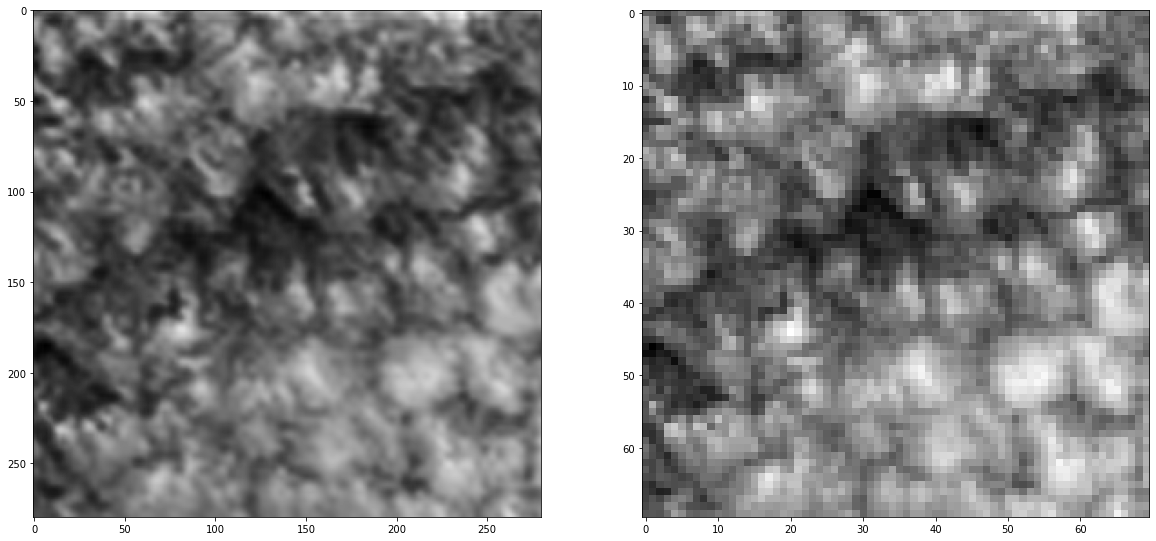

In [143]:
idx_of_interest = 28
fig, ax = py.subplots(1,2, figsize = (20,20))
cs = ax[0].imshow(data[idx_of_interest,:,:,0][:70*4,:70*4], cmap ='gray')#,vmin =0, vmax =0.8)
cs2 = ax[1].imshow(X_test[idx_of_interest,:,:][:70,:70], cmap='gray')#,vmin =0, vmax =0.8)
#ax4 = fig.add_axes([0.95,0.25,0.01,0.5])
#fig.colorbar(cs, cax = ax4)

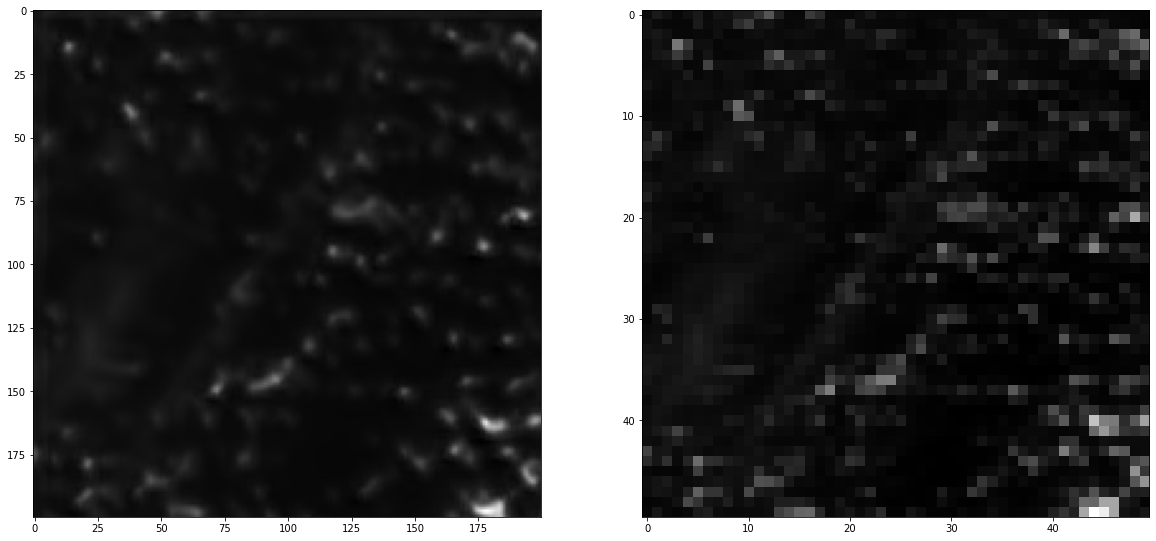

In [150]:
idx_of_interest = 33
fig, ax = py.subplots(1,2, figsize = (20,20))
cs = ax[0].imshow(data[idx_of_interest,:,:,0][:50*4,:50*4], cmap ='gray')#,vmin =0, vmax =0.8)
cs2 = ax[1].imshow(X_test[idx_of_interest,:,:][:50,:50], cmap='gray')#,vmin =0, vmax =0.8)
#ax4 = fig.add_axes([0.95,0.25,0.01,0.5])
#fig.colorbar(cs, cax = ax4)idx_of_interest],cmap='gray')
